In [1]:
# For array manipulation and data handling
import numpy as np
import pandas as pd
import os

# For image processing
from PIL import Image

# For splitting the dataset
from sklearn.model_selection import train_test_split

# TensorFlow and Keras for building the CNN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Reshape, multiply, Add
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


In [2]:
def load_dataset(fname=None):
    if fname is None:
        # Assume we are in the utils folder and get the absolute path to the
        # parent directory.
        fname = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                             os.path.pardir))
        fname = os.path.join(fname, 'labels.csv')

    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=[
                         'path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    def load_cell_image(fname):
        with Image.open(fname) as image:
            return np.asarray(image)

    dir = os.path.dirname(fname)

    images = np.array([load_cell_image(os.path.join(dir, fn))
                       for fn in image_fnames])

    return images, probs, types

In [3]:
def preprocess_and_split(images, probs, types):
    # Add channel dimension for grayscale images
    images_reshaped = np.expand_dims(images, axis=-1)

    # Normalize images
    images_normalized = images_reshaped / 255.0

    # Convert probs to categorical labels
    labels = convert_probs_to_labels(probs)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        images_normalized, labels, test_size=0.25, stratify=labels, random_state=42
    )

    return X_train, X_test, y_train, y_test




def convert_probs_to_labels(probs):
    # Convert probabilities to categorical labels
    # 0% -> 3 (fully functional), 33% -> 2 (possibly defective), 
    # 67% -> 1 (likely defective), 100% -> 0 (certainly defective)
    labels = np.round(probs * 3).astype(int)
    labels = 3 - labels  # Invert the scale so that 0% becomes 3 and 100% becomes 0
    return labels



images, probs, types = load_dataset("elpv-dataset/labels.csv")
X_train, X_test, y_train, y_test = preprocess_and_split(images, probs, types)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Reshape, multiply

def squeeze_excite_block(input, ratio=16):
    """Create a squeeze-and-excitation block."""
    init = input
    channel_axis = -1  # assuming channels last format
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)

    x = multiply([init, se])
    return x

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def create_se_model(input_shape):
    """Create a CNN model with squeeze-and-excitation blocks using Functional API."""
    inputs = Input(shape=input_shape)

    # Convolutional Layer 1
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = squeeze_excite_block(x)
    x = MaxPooling2D((2, 2))(x)

    # Convolutional Layer 2
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = squeeze_excite_block(x)
    x = MaxPooling2D((2, 2))(x)

    # Convolutional Layer 3
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = squeeze_excite_block(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)  # Assuming 4 classes

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Create the SE model
model = create_se_model(X_train.shape[1:])


In [5]:

# def create_model(input_shape):
#     model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#         MaxPooling2D((2, 2)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation='relu'),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.5),
#         Dense(4, activation='softmax')  # 4 classes
#     ])

#     model.compile(optimizer='adam', 
#                   loss='sparse_categorical_crossentropy', 
#                   metrics=['accuracy'])
    
#     return model

# # Create the model
# model = create_model(X_train.shape[1:])  



In [6]:
# Define the number of epochs and batch size
epochs = 10
batch_size = 32
# Define lr
learning_rate = 0.001 

# Create the optimizer with your custom learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

# Include this callback in your model's fit method
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.2, callbacks=[reduce_lr])


Epoch 1/10
50/50 [==============================] - 96s 2s/step - loss: 1.0955 - accuracy: 0.5457 - val_loss: 1.1111 - val_accuracy: 0.5279 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 92s 2s/step - loss: 0.9921 - accuracy: 0.6258 - val_loss: 1.0653 - val_accuracy: 0.6168 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 82s 2s/step - loss: 0.9783 - accuracy: 0.6404 - val_loss: 1.0770 - val_accuracy: 0.6624 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 84s 2s/step - loss: 0.9512 - accuracy: 0.6607 - val_loss: 0.9898 - val_accuracy: 0.6548 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - 84s 2s/step - loss: 0.9619 - accuracy: 0.6582 - val_loss: 1.0752 - val_accuracy: 0.6168 - lr: 0.0010
Epoch 6/10
50/50 [==============================] - 82s 2s/step - loss: 0.9428 - accuracy: 0.6537 - val_loss: 1.0536 - val_accuracy: 0.6650 - lr: 0.0010
Epoch 7/10
50/50 [==============================] - 84s 2s/step - loss: 0.9020 - a

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict the test set results
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification report for F1 score and overall accuracy
report = classification_report(y_test, y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
print("\nClassification Report:")
print(report)


21/21 [==============================] - 6s 261ms/step
Confusion Matrix:
[[101   0   0  78]
 [  1   0   0  25]
 [ 11   0   0  63]
 [ 25   0   0 352]]

Classification Report:
                     precision    recall  f1-score   support

   Fully Functional       0.73      0.56      0.64       179
 Possibly Defective       0.00      0.00      0.00        26
   Likely Defective       0.00      0.00      0.00        74
Certainly Defective       0.68      0.93      0.79       377

           accuracy                           0.69       656
          macro avg       0.35      0.37      0.36       656
       weighted avg       0.59      0.69      0.63       656



/Users/harshbhatia/Documents/comp9517/ass1/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/harshbhatia/Documents/comp9517/ass1/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/harshbhatia/Documents/comp9517/ass1/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

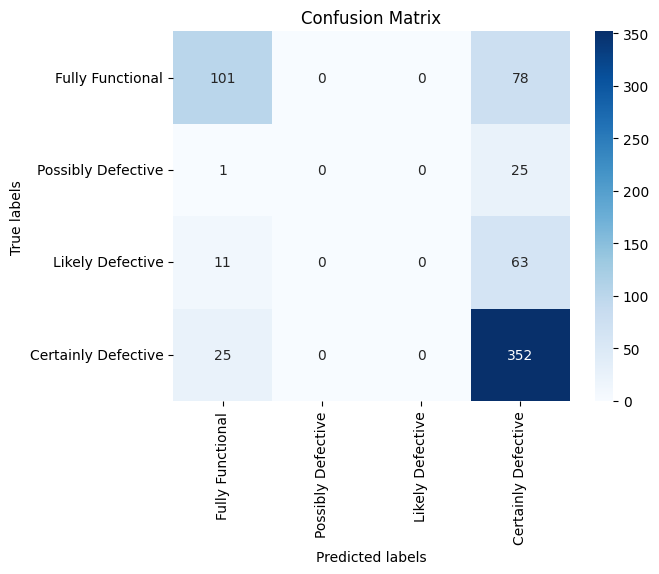

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], yticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


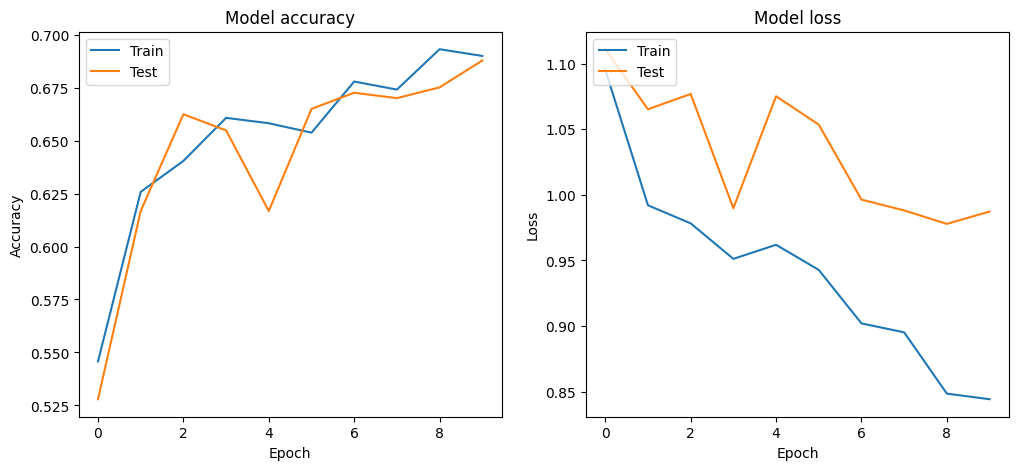

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [10]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate the report
report = classification_report(y_test, y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()


/Users/harshbhatia/Documents/comp9517/ass1/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/harshbhatia/Documents/comp9517/ass1/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/harshbhatia/Documents/comp9517/ass1/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

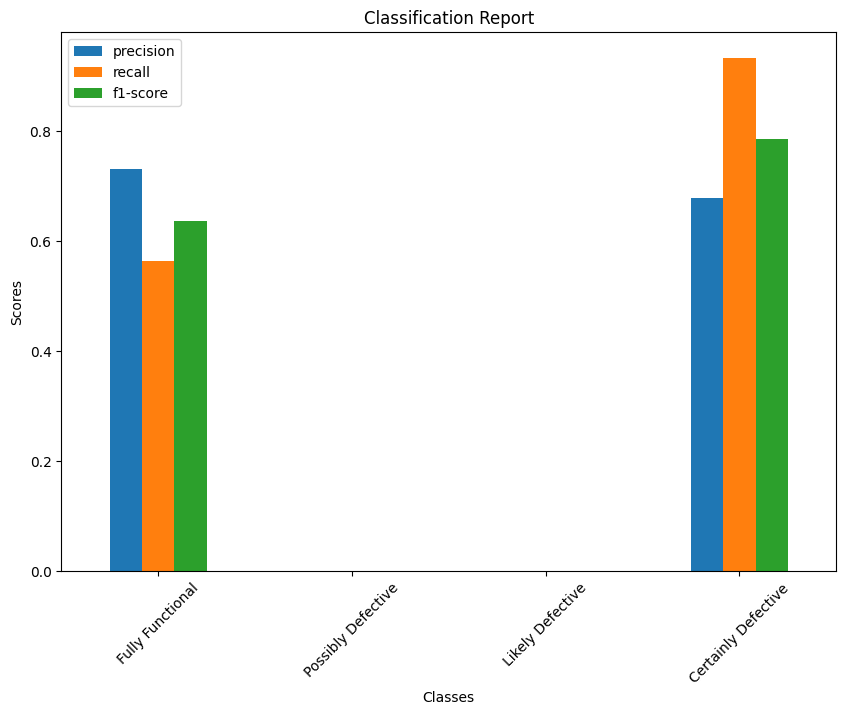

In [11]:
# Drop the support row
report_df = report_df.drop('support', axis=1)

# Plotting
report_df[:-3].plot(kind='bar', figsize=(10, 7))
plt.title('Classification Report')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.show()
